In [7]:
# Some standard import statements

import sys
import os
import logging

import numpy as np

from scipy.optimize import curve_fit

from IPython import get_ipython
ipython = get_ipython()
ipython.magic('load_ext autoreload')
ipython.magic('autoreload 2')
ipython.magic('matplotlib inline')

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

import time

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

from ipynb.fs.defs.p_beam_fluctuation import *

# importing my model functions for analysis
from psi_transmission.model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# sD2 Surface Degradation - Absolute UCN Detection over Time

In [this article](https://link.springer.com/article/10.1140/epja/i2018-12594-2), a mechanism is suggested for the observed degradation of the absolute UCN detection rate in measurements at PSI. 

(!!! review and q's)

(!!! was their model even linear?)

## Loading UCN Run Data

In an effort to reflect on the totality of the analysis here, the data loading function is shown below, with verbose commenting.

In [8]:
###############################################################################

def load_main_data(config, run_type, start_point = 'p_beam', normalize_flag = True):
    """A function to load data and sum counts for individual runs.
    
    Arguments:
        config {string} -- A string that determines the experimental 
            configuration of the data to be loaded. The options are:
                'NORM' - normalization
                'JPTI' - JP Ti guide with NiP
                'JPSU' - JP SUS guide with NiP
                'DISK' - SS Disk
                'GD01' - UGD01 guide
                'GD03' - UGD03 guide
                'EPSU' - EP SUS guide with NiP
        run_type {string} -- A string that determines what type of data will be 
            loaded. The options are:
                'shot' - direct shot measurements 
                's005' - 5 second storage
                's020' - 20 second storage
                's100' - 100 second storage
        start_point {string} -- A string to determine what start point will be
            used as a reference for all time stamps. Options are:
                'p_beam' - start at the first measurement from the proton 
                beam data
        normalize_flag {boolean, optional} -- Flag to normalize the data 
            accroding to a series of routines dependent on run_type. Defaults
            to True.
    
    Returns:
        numpy.float64 -- An n x 5 data array of the results from loading the
            run data. The number of rows corresponds to the number of runs
            loaded. The five columns are:
                0 - the run start time in seconds since the experimental start
                1 - the storage time (0 if direct shot)
                2 - the number of UCN counts
                3 - sqrt(N) error in number of UCN counts
                4 - [day].[run number] of measurement
    """
    
    # initialize an empty array to hold the loaded data
    data = np.zeros((1,5))
    
    if (start_point == 'p_beam'):
        
        first_run_time = get_first_p_beam_time()
    
    # perform the source_normalization routine to retrive fit parameters
    if (normalize_flag):
        norm_parameters, norm_errors = source_normalization(run_type)

    # Every file in the directory containing main detector run data is iterated over.
    # Here the /sorted directory contains just runs deemed good for analysis.
    for filename in os.listdir('../data_main/sorted'):

        # Only the files matching our desired configuration and run type are 
        # selected. The '.tof' condition is just so we don't perform the
        # analysis twice per run.
        if ((config in filename) and (run_type in filename) and 
        ('.tof' in filename)):

            # open the text file associated with the run
            f = open( '../data_main/sorted/' + filename[0:22] + '.txt')  
            lines = f.readlines()
            f.close()
            
            # grab the epoch time for run start
            date_time = filename[1:3].zfill(2) + '.12.2017 ' + lines[26][15:23]
            pattern = '%d.%m.%Y %H:%M:%S'
            run_start_time = int(time.mktime(time.strptime(date_time, pattern)))
            
            # This function returns the start time of the very first run. 
            run_start_time = run_start_time - first_run_time

            # if the run_type is shot, then storage time is set to 0
            if (run_type == "shot"):

                storage_time = 0

            # otherwise grab the storage time from the run type
            else:

                storage_time = int(run_type[1:4])

            # The data is retrieved from the .tof file
            count_data = np.loadtxt('../data_main/sorted/' + filename[0:22] + 
            '.tof', usecols = (1))

            # specific data cut for run 35 on the 8th
            if ((filename[2:3] == '8') and (filename[10:12] == '35')):

                counts = np.sum(count_data[150:1000])

            # specific data cut for run 66 on the 8th
            elif ((filename[2:3] == '8') and (filename[10:12] == '66')):

                counts = np.sum(count_data[150:1500])

            # specific data cut for run 88 on the 8th
            elif ((filename[2:3] == '8') and (filename[10:12] == '88')):

                counts = np.sum(count_data[150:2500])

            # cut the data normally
            else:

                counts = np.sum(count_data[150:-1])

            # normalize the data depending on the normalize_flag
            # !!! Note that this normalization operatin is not taking into account the need
            # to correct based on absolute counts. i.e. here the direct shot has 
            # a linear slope of ~-8, whereas the storage time measurements will be more 
            # like -0.2. This is wrong, must be corrected.
            if (normalize_flag):
                extrap_counts = source_fit(0, norm_parameters[0], 
                                          norm_parameters[1])
                interp_counts = source_fit(run_start_time, norm_parameters[0], 
                                           norm_parameters[1])
                
                
                norm_factor = extrap_counts / interp_counts
                
                counts = counts * norm_factor
                

            # if this is the first file loaded, then assign the values to the data array, otherwise
            # append the vector of values to the existing array
            if (data[0,0] == 0):

                data[0,0] = run_start_time
                data[0,1] = storage_time
                data[0,2] = counts
                data[0,3] = np.sqrt(counts)

                # saving the [day].[run number] can be useful for debugging
                # requires enlarging the arrays
                data[0,4] = int(filename[1:3]) + \
                (0.001 * int(filename[9:12]))

            # otherwise we make a vector and append it
            else:

                run_data = np.zeros((1,5))
                run_data[0,0] = run_start_time
                run_data[0,1] = storage_time
                run_data[0,2] = counts 
                run_data[0,3] = np.sqrt(counts)

                # saving the [day].[run number] can be useful for debugging
                # requires enlarging the arrays
                run_data[0,4] = int(filename[1:3]) + \
                (0.001 * int(filename[9:12]))
                
                data = np.vstack((data, run_data))
    
    # we return the data sorted by time
    return data[data[:,0].argsort()]

In [ ]:
###############################################################################

# (!!!) This project is to 

def load_all_data(config, run_type, start_point = 'p_beam', normalize_flag = True):
    """A function to load data and sum counts for individual runs.
    
    Arguments:
        config {string} -- A string that determines the experimental 
            configuration of the data to be loaded. The options are:
                'NORM' - normalization
                'JPTI' - JP Ti guide with NiP
                'JPSU' - JP SUS guide with NiP
                'DISK' - SS Disk
                'GD01' - UGD01 guide
                'GD03' - UGD03 guide
                'EPSU' - EP SUS guide with NiP
        run_type {string} -- A string that determines what type of data will be 
            loaded. The options are:
                'shot' - direct shot measurements 
                's005' - 5 second storage
                's020' - 20 second storage
                's100' - 100 second storage
        start_point {string} -- A string to determine what start point will be
            used as a reference for all time stamps. Options are:
                'p_beam' - start at the first measurement from the proton 
                beam data
        normalize_flag {boolean, optional} -- Flag to normalize the data 
            accroding to a series of routines dependent on run_type. Defaults
            to True.
    
    Returns:
        numpy.float64 -- An n x 5 data array of the results from loading the
            run data. The number of rows corresponds to the number of runs
            loaded. The five columns are:
                0 - the run start time in seconds since the experimental start
                1 - the storage time (0 if direct shot)
                2 - the number of UCN counts
                3 - sqrt(N) error in number of UCN counts
                4 - [day].[run number] of measurement
    """
    
    # initialize an empty array to hold the loaded data
    data = np.zeros((1,5))
    
    if (start_point == 'p_beam'):
        
        first_run_time = get_first_p_beam_time()
    
    # perform the source_normalization routine to retrive fit parameters
    if (normalize_flag):
        norm_parameters, norm_errors = source_normalization(run_type)

    # Every file in the directory containing main detector run data is iterated over.
    # Here the /sorted directory contains just runs deemed good for analysis.
    for filename in os.listdir('../data_main/sorted'):

        # Only the files matching our desired configuration and run type are 
        # selected. The '.tof' condition is just so we don't perform the
        # analysis twice per run.
        if ((config in filename) and (run_type in filename) and 
        ('.tof' in filename)):

            # open the text file associated with the run
            f = open( '../data_main/sorted/' + filename[0:22] + '.txt')  
            lines = f.readlines()
            f.close()
            
            # grab the epoch time for run start
            date_time = filename[1:3].zfill(2) + '.12.2017 ' + lines[26][15:23]
            pattern = '%d.%m.%Y %H:%M:%S'
            run_start_time = int(time.mktime(time.strptime(date_time, pattern)))
            
            # This function returns the start time of the very first run. 
            run_start_time = run_start_time - first_run_time

            # if the run_type is shot, then storage time is set to 0
            if (run_type == "shot"):

                storage_time = 0

            # otherwise grab the storage time from the run type
            else:

                storage_time = int(run_type[1:4])

            # The data is retrieved from the .tof file
            count_data = np.loadtxt('../data_main/sorted/' + filename[0:22] + 
            '.tof', usecols = (1))

            # specific data cut for run 35 on the 8th
            if ((filename[2:3] == '8') and (filename[10:12] == '35')):

                counts = np.sum(count_data[150:1000])

            # specific data cut for run 66 on the 8th
            elif ((filename[2:3] == '8') and (filename[10:12] == '66')):

                counts = np.sum(count_data[150:1500])

            # specific data cut for run 88 on the 8th
            elif ((filename[2:3] == '8') and (filename[10:12] == '88')):

                counts = np.sum(count_data[150:2500])

            # cut the data normally
            else:

                counts = np.sum(count_data[150:-1])

            # normalize the data depending on the normalize_flag
            # !!! Note that this normalization operatin is not taking into account the need
            # to correct based on absolute counts. i.e. here the direct shot has 
            # a linear slope of ~-8, whereas the storage time measurements will be more 
            # like -0.2. This is wrong, must be corrected.
            if (normalize_flag):
                extrap_counts = source_fit(0, norm_parameters[0], 
                                          norm_parameters[1])
                interp_counts = source_fit(run_start_time, norm_parameters[0], 
                                           norm_parameters[1])
                
                
                norm_factor = extrap_counts / interp_counts
                
                counts = counts * norm_factor
                

            # if this is the first file loaded, then assign the values to the data array, otherwise
            # append the vector of values to the existing array
            if (data[0,0] == 0):

                data[0,0] = run_start_time
                data[0,1] = storage_time
                data[0,2] = counts
                data[0,3] = np.sqrt(counts)

                # saving the [day].[run number] can be useful for debugging
                # requires enlarging the arrays
                data[0,4] = int(filename[1:3]) + \
                (0.001 * int(filename[9:12]))

            # otherwise we make a vector and append it
            else:

                run_data = np.zeros((1,5))
                run_data[0,0] = run_start_time
                run_data[0,1] = storage_time
                run_data[0,2] = counts 
                run_data[0,3] = np.sqrt(counts)

                # saving the [day].[run number] can be useful for debugging
                # requires enlarging the arrays
                run_data[0,4] = int(filename[1:3]) + \
                (0.001 * int(filename[9:12]))
                
                data = np.vstack((data, run_data))
    
    # we return the data sorted by time
    return data[data[:,0].argsort()]

## Measuring Total UCN Counts per Nominal Run; by Pre-Storage Time

By 'nominal' I refer to the guide-less configuration, pictured below (from Edgard's slides).

![](../misc/nominal_configuration.png)
![](jonahberean/psi_transmission/misc/nominal_configuration.png)

In this section, only the runs carried out in this configuration are used. Transmission ratios were found by Edgard to be ~0.5-0.9 for the various guides, and these measurements would need to be used in a re-normalization of the absolute counts before any comparison with nominal configuration runs.

(!!!)

(!!! It might be useful to plot each pre-storage time data set separately, to get a better sense of the error bar v. spread of data picture. 

The error bar v. spread of the data suggests that there are systematic effects at play here that are not being properly accounted for with this simplistic linear model of sD2 degradation.

## Comparing UCN Count Degradation Rates for Different Pre-Storage Times

In order to compare the degradation rates - the slopes from the most recent figure - the rates must be re-scaled by the absolute count rates at time $t = 0$, the beginning of the experiment. 

(!!!)

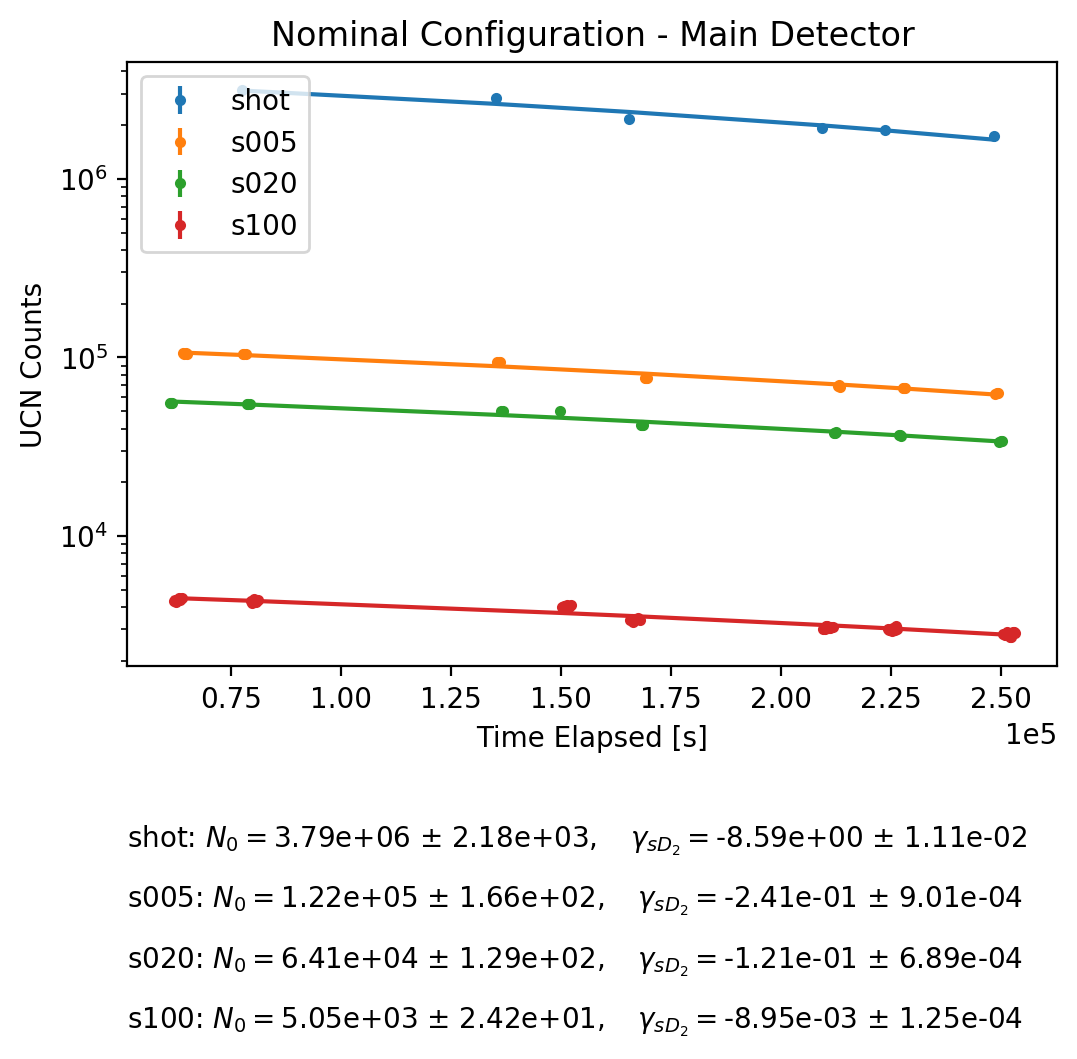

In [10]:
# (!!!) comment properly
def linear_fit(t, N_0, A):
    return N_0 + A * t

def ucn_yield():
    # the data is loaded into a dictionary, callable by pre-storage time or
    # 'run_type'
    run_type_list = ['shot', 's005', 's020', 's100']
    nominal_main_data = {}

    # for colour consistency in plotting
    ax = plt.gca()

    # for counting loop iterations
    text_y_coord = -0.2

    for run_type in run_type_list:

        # loading into the dictionary
        nominal_main_data[run_type] = load_main_data('NORM', run_type, 
                                                     start_point = 'p_beam',
                                                     normalize_flag = False)

        # defining a separate variable for more readable plotting code
        arr = nominal_main_data[run_type]

        # for colour consistency in plotting
        color = next(ax._get_lines.prop_cycler)['color']

        # plotting the data by pre-storage time
        plt.errorbar(arr[:,0], arr[:,2], yerr = arr[:,3], fmt = '.',
                     label = run_type, color = color)

        # performing a linear fit
        popt, pcov = curve_fit(linear_fit, arr[:,0], arr[:,2], 
                               sigma = arr[:,3], absolute_sigma = True)
        plt.plot(arr[:,0], linear_fit(arr[:,0], *popt), color = color);

        # saving the fit results to the dictionary
        fit_result = np.zeros(np.shape(pcov))
        for i in range(0, np.size(popt)):
            fit_result[i,0] = popt[i]
            fit_result[i,1] = np.sqrt(np.diag(pcov))[i]
        nominal_main_data['fit_' + run_type] = fit_result

        # printing the fit results below the figure
        text_y_coord = text_y_coord - 0.1
        plt.text(0, text_y_coord, run_type 
                 + r': $N_0 = $%.2e $\pm $ %.2e$, \quad \gamma_{sD_2} = $%.2e $ \pm $ %.2e' % (
                     decimal.Decimal(fit_result[0,0]), 
                     decimal.Decimal(fit_result[0,1]),
                     decimal.Decimal(fit_result[1,0]), 
                     decimal.Decimal(fit_result[1,1])),
                 transform=ax.transAxes);

    # presentation stuff
    plt.yscale('log')
    plt.xlabel('Time Elapsed [s]');
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ylabel('UCN Counts');
    plt.legend();
    plt.title('Nominal Configuration - Main Detector');
    
ucn_yield()

## Using the Spread of Re-Scaled Loss Rates as an Error Bar

Alternatively, the spread of these re-scaled loss rate values could be used to define an error bar on the normalization itself. If this is done, a pre-storage lifetime measurement using nominal configuration data yields the following plot.

(!!!)

(Do the error bars better represent the spread of the data?)

## Time (therefore Energy?) Bin - Absolute Dependent UCN Detection 

Perhaps a more granular view is achieved from an analysis that looks at how specific time bins perform over time.

## Analysis of the Monitor Detector Counts

Thus far we have only reviewed the data from the main detector, but we could also look at the data from the monitor detector that is attached to the source vessel. 

(!!! heights from the EPJ paper, do we see the correct relative count rate magnitudes between the monitor and main on a direct shot?)

(!!! explanatory schematic)

(!!! could the cyclotron beam timing data tell us something about what happened during the low count period of the monitor detector? If Bernhard is right, then that mis-synchronization should be observable)

(!!! multiple fits)

## Conclusions